# INDIVIDUAL ASSIGNMENT

## Alexis CHATAIL--RIGOLLEAU

The present notebook is my implementation of the MonteCarlo and SARSA Agents performing reinforcement learning for the Flappy Bird game

## Import

In [18]:
import random
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import defaultdict 
import torch
from tqdm import tqdm
import torch
import text_flappy_bird_gym
import time

## Set up of the environment 

In [19]:

env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

## Monte-Carlo Agent

In [20]:

class MonteCarloAgent:
    def __init__(self, action_space, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995, gamma=0.99):
        """
        action_space   : espace d'actions de l'environnement
        epsilon        : valeur initiale pour l'exploration
        epsilon_min    : valeur minimale de epsilon
        epsilon_decay  : facteur de décroissance de epsilon après chaque épisode
        gamma          : taux d'actualisation
        """
        
        self.Q = {}       
        self.returns = {} 
        self.action_space = action_space
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma

    def get_state(self, state):
        """Convertit l'état en un format hashable (ici un tuple)."""
        if isinstance(state, np.ndarray):
            return tuple(state.flatten())
        return state

    def policy(self, state):
        """
        Stratégie epsilon-greedy :
        - Avec probabilité epsilon, on choisit une action aléatoire.
        - Sinon, on choisit l'action ayant la plus grande valeur Q.
        """
        state = self.get_state(state)
        
        if state not in self.Q:
            self.Q[state] = np.zeros(self.action_space.n)
        if np.random.rand() < self.epsilon:
            return self.action_space.sample()
        else:
            return int(np.argmax(self.Q[state]))

    def update(self, episode):
        """
        Mise à jour de la table Q par méthode Monte Carlo (first-visit MC).
        L'épisode est une liste de tuples (état, action, reward).
        """
        G = 0
        visited = set()
        
        for state, action, reward in reversed(episode):
            state = self.get_state(state)
            G = self.gamma * G + reward
            if (state, action) not in visited:
                
                if (state, action) not in self.returns:
                    self.returns[(state, action)] = []
                self.returns[(state, action)].append(G)
                
                self.Q[state][action] = np.mean(self.returns[(state, action)])
                visited.add((state, action))


**I changed the hyperparameters of the MonteCarloAgent in order to maximize the Agent's performance, and I added and espilon_decay parameter** 

### Training of the Monte-Carlo Agent

**Parameter sweep**

In [21]:

def evaluate_agent(agent, env, best_limit, num_games=10):
    """Returns the mean score of num_games games of a evaluated agent, with exploration parameter set to 0 

    Args:
        agent   : trained agent to evaluate
        env     : environment
        best_limit (int): previous best score 
        num_games (int, optional): number of games to be played. Defaults to 10.

    Returns:
        Mean of the scores of the num_games games.
    """
    old_epsilon = agent.epsilon
    agent.epsilon = 0.0 
    scores = []
    for _ in range(num_games):
        state, info = env.reset()
        state = agent.get_state(state)
        done = False
        episode_reward = 0
        action = agent.policy(state)
        while not done:
            next_state, reward, done, _, info = env.step(action)
            next_state = agent.get_state(next_state)
            episode_reward += reward
            if not done:
                action = agent.policy(next_state)
           
            if episode_reward > 2 * best_limit:
                break
        scores.append(episode_reward)
    agent.epsilon = old_epsilon  
    return np.mean(scores)

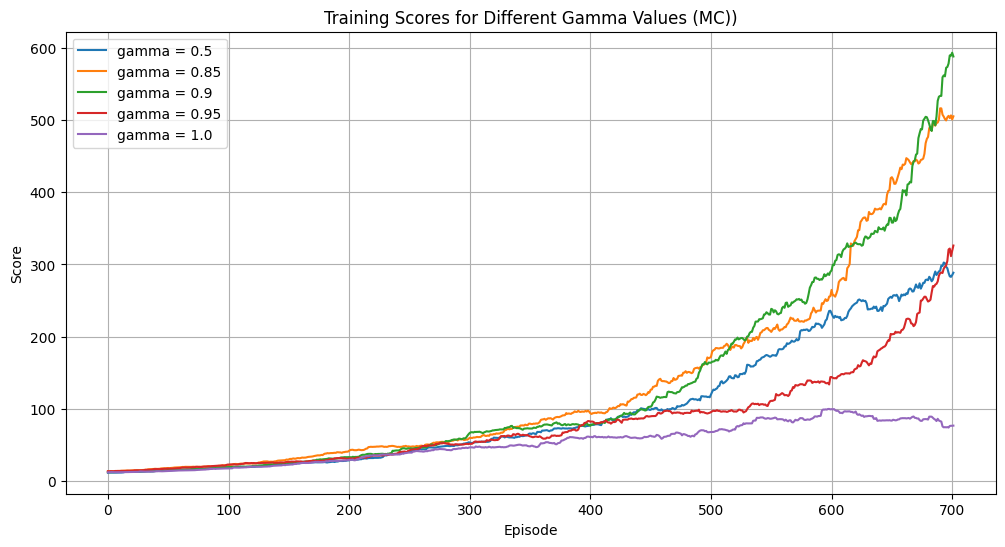

In [22]:
num_episodes =600
gamma_values = [0.5,0.85,0.9,0.95,1.0]

num_episodes = 800
results = {}
best_score = -np.inf
for gam in gamma_values:
    agent =  MonteCarloAgent(
    action_space=env.action_space, 
    epsilon=1.0,         
    epsilon_min=0.01,    
    epsilon_decay=0.995, 
    gamma=gam           
)
    scores = []
    
    for episode in range(num_episodes):
        state, info = env.reset()
        done = False
        episode_reward = 0
        episode_data = []  
        
        while not done:
            action = agent.policy(state)
            next_state, reward, done, _, info = env.step(action)
            episode_data.append((state, action, reward))
            state = next_state
            episode_reward += reward

            if episode_reward>2*best_score:
                break
        
        agent.update(episode_data)
        
        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
        scores.append(episode_reward)
        
        
        if episode_reward > best_score:
            avg_candidate_score = evaluate_agent(agent, env,best_score, num_games=10)
            
            if avg_candidate_score > best_score:
                best_score = avg_candidate_score
                torch.save(agent, 'best_agent.pth')
        
    agent.update(episode_data)

    scores.append(episode_reward)
    agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay) 
    results[str(gam)] = scores
wd = 100
plt.figure(figsize=(12, 6))
for gamma in gamma_values:
    lbl = "gamma = " + str(gamma)
    plt.plot(range(0, len(results[str(gamma)])-wd+1), np.convolve(results[str(gamma)], np.ones(wd)/wd, mode='valid'),label=lbl)

plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Training Scores for Different Gamma Values (MC))')
plt.legend()
plt.grid(True)
plt.show()

Our training process is as followed :

- We train our Monte-Carlo Agent on flappy bird games, with an epsilon decay exploration parameter strategy.
- We compute the score (reward) of the agent for each episode
- We see that there is high variance on the result from an episode to the following, so we can't simply take the agent after training, because we might have missed a higher performance agent during the process, so we're gonna compute the best agent during training.

To do that :  
- If an agent performs better than our previous best agent, this new agent is consider as a new **best_agent**.
- However, while retrieving the best agent that way, I saw that this agent might actually perform poorly on new test flappy bird games, because the agent's previous score might have been a lucky situation, where pipes were aligned in a manner that the agent performed well. Therefore, the new agent isn't considered directly as our new **best_agent** but is considered as a candidate for **best_agent**.  

To become our new **best_agent**, the agent goes through the **evaluate_agent** function in the training loop : 

we run 10 flappy bird games with our agent (with its epsilon exploration set to 0), and we check wether the average score is higher that our previous best score. Some agents can be very good at the game, so we limit the score to 2 times the best previous score, so that we don't have an infinite loop

In [26]:

agent = MonteCarloAgent(
    action_space=env.action_space, 
    epsilon=1.0,         
    epsilon_min=0.01,    
    epsilon_decay=0.995, 
    gamma=0.9           
)

In [27]:

num_episodes = 4000  
scores = []
best_score = -np.inf  

progress_bar = tqdm(range(num_episodes), desc="Episodes", unit="itération")
for episode in progress_bar:
    state, info = env.reset()
    done = False
    episode_reward = 0
    episode_data = []  
    
    while not done:
        action = agent.policy(state)
        next_state, reward, done, _, info = env.step(action)
        episode_data.append((state, action, reward))
        state = next_state
        episode_reward += reward

        if episode_reward>2*best_score:
            break
    
    agent.update(episode_data)
    
    agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
    scores.append(episode_reward)
    
    
    if episode_reward > best_score:
        avg_candidate_score = evaluate_agent(agent, env,best_score, num_games=10)
        
        if avg_candidate_score > best_score:
            best_score = avg_candidate_score
            torch.save(agent, 'best_agent.pth')
    progress_bar.set_postfix(best_score=best_score, current_reward=episode_reward)


Episodes: 100%|██████████| 4000/4000 [01:26<00:00, 46.21itération/s, best_score=9336.0, current_reward=73]  


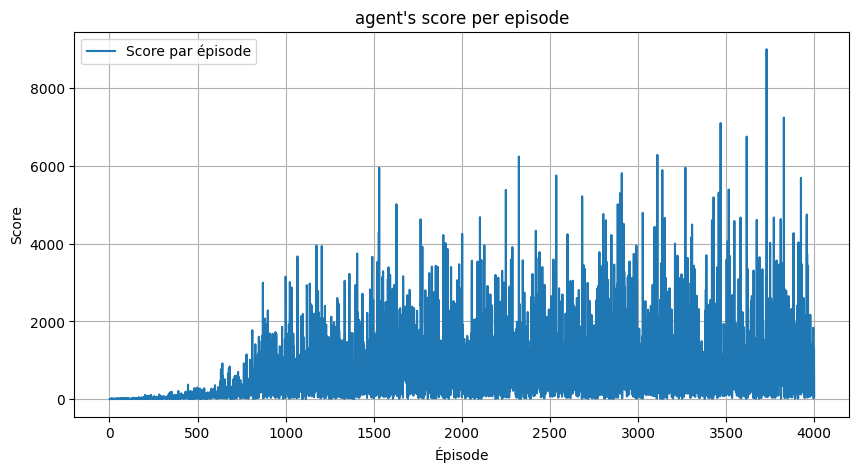

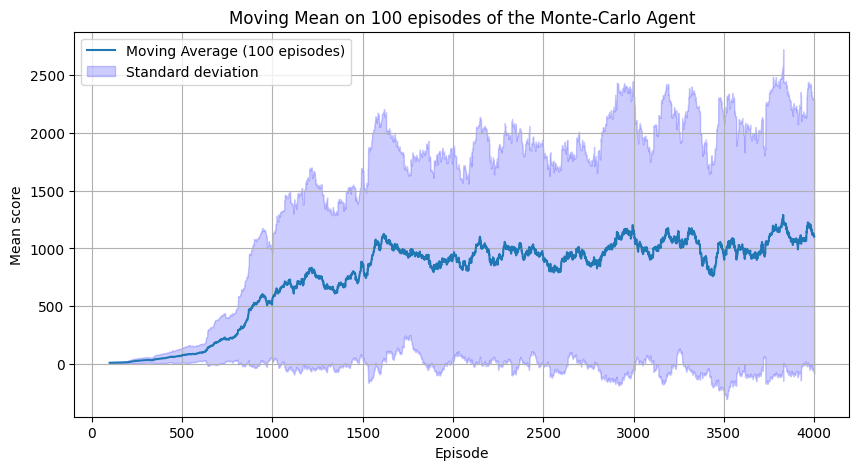

In [29]:



plt.figure(figsize=(10, 5))
plt.plot(range(1, num_episodes+1), scores, label='Score par épisode')
plt.xlabel("Épisode")
plt.ylabel("Score")
plt.title("agent's score per episode")
plt.legend()
plt.grid(True)
plt.show()

window_size = 100

moving_avg = np.convolve(scores, np.ones(window_size)/window_size, mode='valid')
moving_std = np.array([np.std(scores[i:i+window_size]) for i in range(len(scores)-window_size+1)])
episodes = np.arange(window_size, len(scores)+1)

plt.figure(figsize=(10, 5))
plt.plot(episodes, moving_avg, label='Moving Average (100 episodes)')
plt.fill_between(episodes, moving_avg - moving_std, moving_avg + moving_std, 
                 color='b', alpha=0.2, label='Standard deviation')
plt.xlabel('Episode')
plt.ylabel('Mean score')
plt.title('Moving Mean on 100 episodes of the Monte-Carlo Agent')
plt.legend()
plt.grid(True)
plt.show()



## Test

Once the **best_agent** has been saved, we retrieve it to play the test games ! If the agent's score is higher than 10000, we consider he plays undefinitely and we break in order not to get an infinite loop. 

In [28]:
best_agent = torch.load('best_agent.pth')

best_agent.epsilon = 0.0 # We don't want exploration

test_games = 20
test_scores = []

for _ in tqdm(range(test_games)):
    state, info = env.reset()
    done = False
    episode_reward = 0
    while not done:
        action = best_agent.policy(state)
        next_state, reward, done, _, info = env.step(action)
        state = next_state
        episode_reward += reward
        
        env.render()
        
        if (episode_reward>10000):
            break
    test_scores.append(episode_reward)
avg_test_score = np.mean(test_scores)
print(f"Average Score of the best agent on {test_games} parties: {avg_test_score:.2f}")


C:\Users\chata\AppData\Local\Temp\ipykernel_19668\1926476974.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_agent = torch.load('best_agent.pth')


100%|██████████| 20/20 [00:30<00:00,  1.54s/it]

Average Score of the best agent on 20 parties: 10001.00


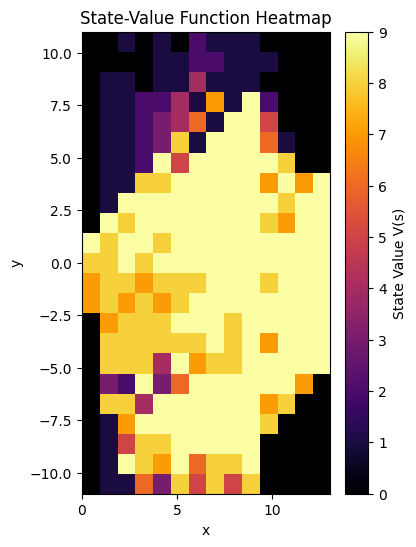

In [30]:
def plot_state_value_function(agent):
    """
    State Value function Heatmap
    """
    width,height = 20,15
    _pipe_gap = 4
    _screen_size = (width,height)
    
    x_max = _screen_size[0]-int(_screen_size[0]*0.3)-1
    x_min = 0
    y_max = _screen_size[1]-1-int(_pipe_gap//2)-1
    y_min = -y_max
    
    num_x = x_max - x_min + 1  
    num_y = y_max - y_min + 1  

    grid = np.full((num_y, num_x), 0)

    for state, q_values in agent.Q.items():
        x, y = state
        if x_min <= x <= x_max and y_min <= y <= y_max:
            col = x - x_min
            row = y - y_min
            grid[row, col] = np.max(q_values)

    plt.figure(figsize=(4, 6))
    extent = [x_min, x_max, y_min, y_max]
    im = plt.imshow(grid, origin='lower', extent=extent, aspect='auto', cmap="inferno", interpolation='nearest')
    plt.colorbar(im, label='State Value V(s)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('State-Value Function Heatmap')
    plt.show()

plot_state_value_function(best_agent)


## SARSA Agent

In [31]:

class SARSAAgentLambda:
    def __init__(self, action_space, alpha=0.05, gamma=0.99, lam=0.9,
                 epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        """
        action_space   : espace d'actions de l'environnement
        alpha          : taux d'apprentissage
        gamma          : facteur d'actualisation
        lam            : paramètre λ pour les traces d'éligibilité
        epsilon        : taux d'exploration initial
        epsilon_min    : valeur minimale de epsilon
        epsilon_decay  : facteur de décroissance d'epsilon après chaque épisode
        """
        self.Q = {} 
        self.action_space = action_space
        self.alpha = alpha
        self.gamma = gamma
        self.lam = lam
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

    def get_state(self, state):
        """Convertit l'état en un format hashable (ici, un tuple)."""
        if isinstance(state, np.ndarray):
            return tuple(state.flatten())
        return state

    def policy(self, state):
        """
        Epsilon greedy strategy :
        """
        state = self.get_state(state)
        if state not in self.Q:
            self.Q[state] = np.zeros(self.action_space.n)
        if np.random.rand() < self.epsilon:
            return self.action_space.sample()
        else:
            return int(np.argmax(self.Q[state]))

    def sarsa_lambda_update(self, state, action, reward, next_state, next_action, done, E):
        """
        We update according to SARSA algorithm
        """
        state = self.get_state(state)
        next_state = self.get_state(next_state)
        if state not in self.Q:
            self.Q[state] = np.zeros(self.action_space.n)
        if next_state not in self.Q:
            self.Q[next_state] = np.zeros(self.action_space.n)
        target = reward
        if not done:
            target += self.gamma * self.Q[next_state][next_action]
        delta = target - self.Q[state][action]
        E[(state, action)] = E.get((state, action), 0) + 1
        for key in list(E.keys()):
            s, a = key
            self.Q[s][a] += self.alpha * delta * E[key]
            E[key] *= self.gamma * self.lam

    


We check the value of lambda maximizing the score

λ = 1.1: 100%|██████████| 400/400 [00:00<00:00, 3031.02episode/s]


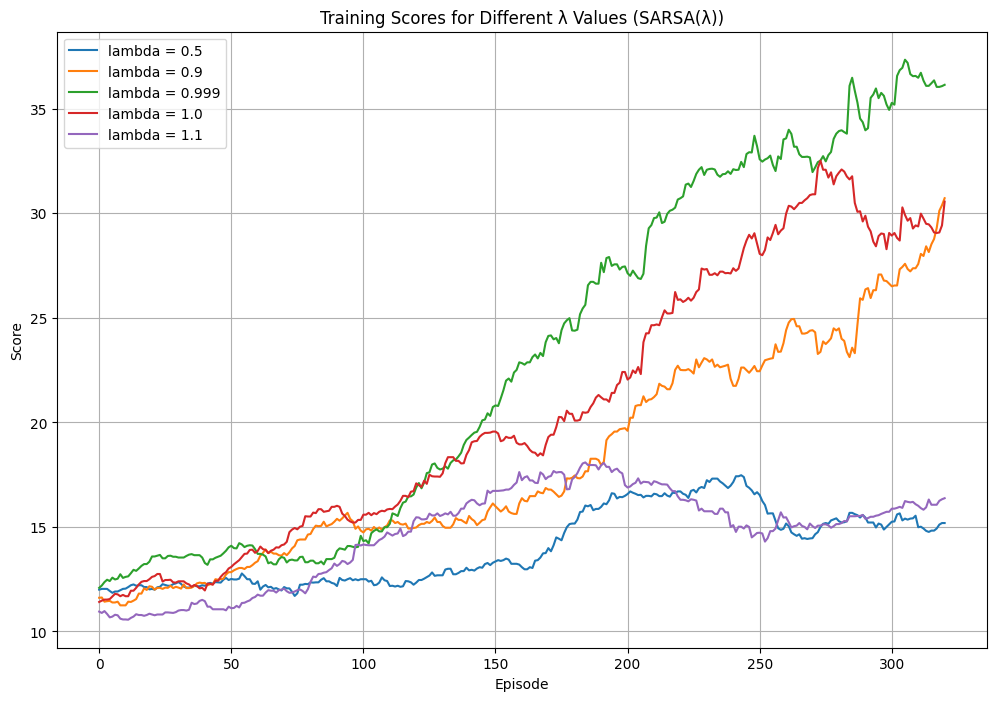

In [32]:
num_episodes =400
lambda_values = [0.5,0.9,0.999,1.0,1.1]


results = {}
    
for lam in lambda_values:
    agent = SARSAAgentLambda(env.action_space, alpha=0.05, gamma=0.99, lam=lam,
                              epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995)
    scores = []
    
    for episode in tqdm(range(num_episodes), desc=f"λ = {lam}", unit="episode"):
        state, info = env.reset()
        state = agent.get_state(state)
        action = agent.policy(state)
        E =  {}
        episode_reward = 0
        done = False
        while not done:
            next_state, reward, done, _, info = env.step(action)
            next_state = agent.get_state(next_state)
            episode_reward += reward
            if not done:
                next_action = agent.policy(next_state)
            else:
                next_action = 0
            agent.sarsa_lambda_update(state, action, reward, next_state, next_action, done, E)
            state = next_state
            action = next_action if not done else 0
        scores.append(episode_reward)
        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay) 
    results[str(lam)] = scores
wd = 80


plt.figure(figsize=(12, 8))
for lam in lambda_values:
    str_lam = str(lam)
    lbl = "lambda = " + str(lam)
    plt.plot(range(0, len(results[str_lam])-wd+1), np.convolve(results[str_lam], np.ones(wd)/wd, mode='valid'),label=lbl)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Training Scores for Different λ Values (SARSA(λ))')
plt.legend()
plt.grid(True)
plt.show()

We do the same thing for gamma

gamma = 1.0: 100%|██████████| 400/400 [00:00<00:00, 2246.20episode/s]


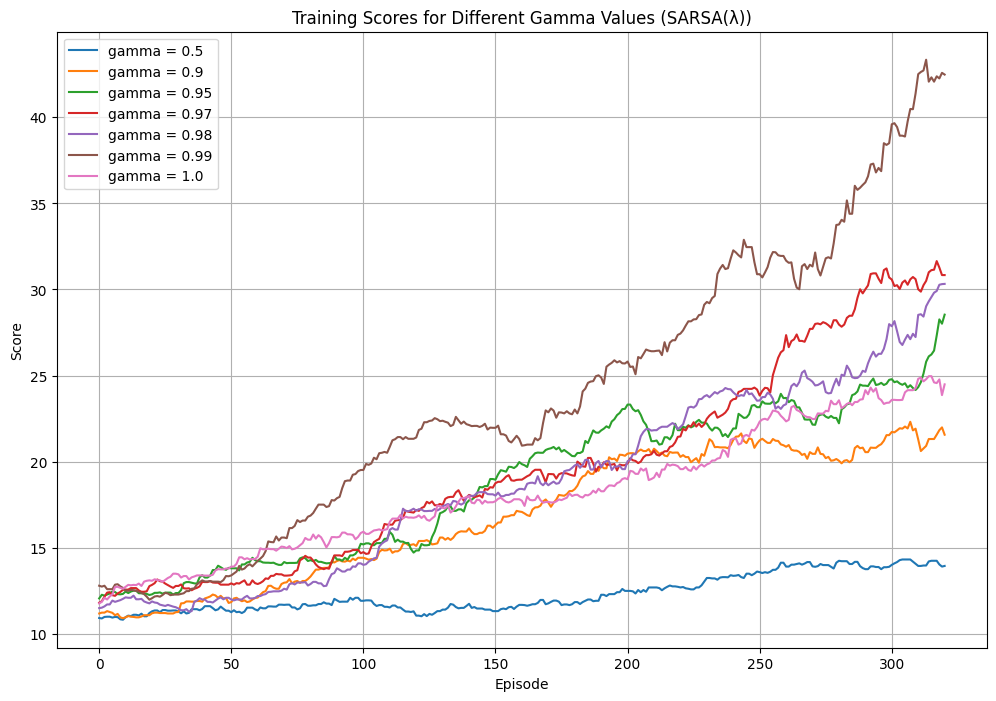

In [33]:
num_episodes =400
gamma_values = [0.5,0.9,0.95,0.97,0.98,0.99,1.0]


results = {}
    
for gam in gamma_values:
    agent = SARSAAgentLambda(env.action_space, alpha=0.05, gamma=gam, lam=1,
                              epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995)
    scores = []
    
    for episode in tqdm(range(num_episodes), desc=f"gamma = {gam}", unit="episode"):
        state, info = env.reset()
        state = agent.get_state(state)
        action = agent.policy(state)
        E =  {}
        episode_reward = 0
        done = False
        while not done:
            next_state, reward, done, _, info = env.step(action)
            next_state = agent.get_state(next_state)
            episode_reward += reward
            if not done:
                next_action = agent.policy(next_state)
            else:
                next_action = 0
            agent.sarsa_lambda_update(state, action, reward, next_state, next_action, done, E)
            state = next_state
            action = next_action if not done else 0
        scores.append(episode_reward)
        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay) 
    results[str(gam)] = scores
wd = 80

plt.figure(figsize=(12, 8))
for gamma in gamma_values:
    lbl = "gamma = " + str(gamma)
    plt.plot(range(0, len(results[str(gamma)])-wd+1), np.convolve(results[str(gamma)], np.ones(wd)/wd, mode='valid'),label=lbl)

plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Training Scores for Different Gamma Values (SARSA(λ))')
plt.legend()
plt.grid(True)
plt.show()

Now that we have done the parameter sweep, we train our model

In [34]:
agent = SARSAAgentLambda(
    action_space=env.action_space,
    alpha=0.1,
    gamma=0.98,
    lam=1,
    epsilon=1.0,
    epsilon_min=0.001,
    epsilon_decay=0.997
)


In [35]:
num_episodes = 2500
scores = []
best_score = -np.inf 


progress_bar = tqdm(range(num_episodes), desc="Episodes", unit="iteration")

for episode in progress_bar:
    state, info = env.reset()
    state = agent.get_state(state)
    action = agent.policy(state)
    E = {}
    episode_reward = 0
    done = False
    while not done:
        next_state, reward, done, _, info = env.step(action)
        next_state = agent.get_state(next_state)
        episode_reward += reward
        if not done:
            next_action = agent.policy(next_state)
        else:
            next_action = None
        agent.sarsa_lambda_update(state, action, reward, next_state, 
                                    next_action if next_action is not None else 0,
                                    done, E)
        state = next_state
        action = next_action if next_action is not None else 0
        if episode_reward > 2 * best_score:
            break
    scores.append(episode_reward)
    agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
    
    if episode_reward > best_score:
        avg_candidate_score = evaluate_agent(agent, env, best_limit=best_score, num_games=10)
        if avg_candidate_score > best_score:
            best_score = avg_candidate_score
            torch.save(agent, 'best_agent.pth')
            
    progress_bar.set_postfix(best_score=best_score, current_reward=episode_reward)



Episodes: 100%|██████████| 2500/2500 [02:45<00:00, 15.11iteration/s, best_score=16912.4, current_reward=2376] 


And we plot the training score & mean training score

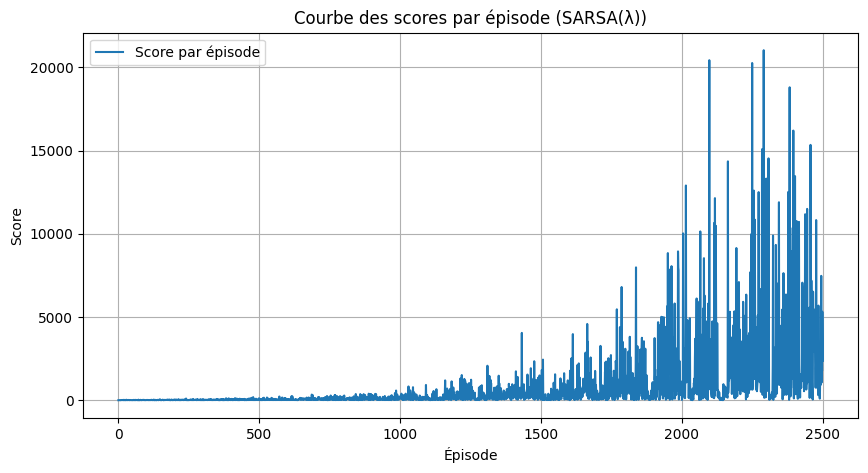

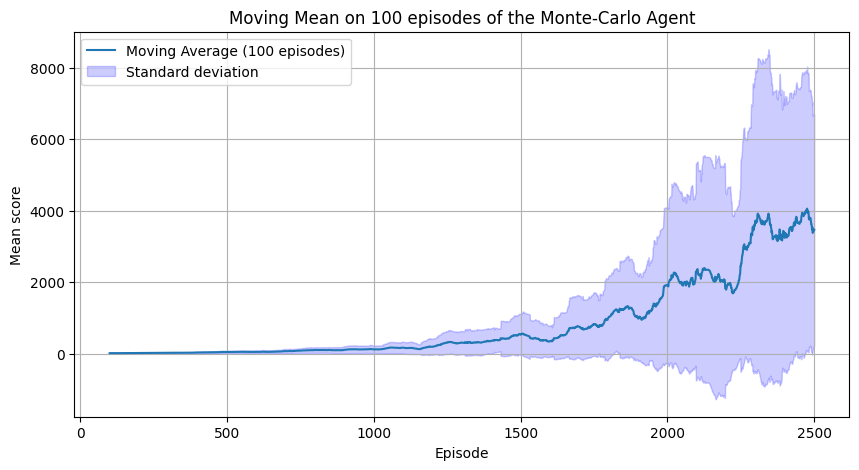

In [36]:

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_episodes+1), scores, label="Score par épisode")
plt.xlabel("Épisode")
plt.ylabel("Score")
plt.title("Courbe des scores par épisode (SARSA(λ))")
plt.legend()
plt.grid(True)
plt.show()

window_size = 100

moving_avg = np.convolve(scores, np.ones(window_size)/window_size, mode='valid')
moving_std = np.array([np.std(scores[i:i+window_size]) for i in range(len(scores)-window_size+1)])
episodes = np.arange(window_size, len(scores)+1)

plt.figure(figsize=(10, 5))
plt.plot(episodes, moving_avg, label='Moving Average (100 episodes)')
plt.fill_between(episodes, moving_avg - moving_std, moving_avg + moving_std, 
                 color='b', alpha=0.2, label='Standard deviation')
plt.xlabel('Episode')
plt.ylabel('Mean score')
plt.title('Moving Mean on 100 episodes of the Monte-Carlo Agent')
plt.legend()
plt.grid(True)
plt.show()


## Test SARSA

In [37]:

# Phase de test : chargement et évaluation du meilleur agent sauvegardé
best_agent_sarsa = torch.load('best_agent.pth')
best_agent_sarsa.epsilon = 0.0  # exploitation pure lors du test
test_games = 50
test_scores = []
for _ in range(test_games):
    state, info = env.reset()
    state = best_agent_sarsa.get_state(state)
    done = False
    episode_reward = 0
    action = best_agent_sarsa.policy(state)
    while not done:
        next_state, reward, done, _, info = env.step(action)
        next_state = best_agent_sarsa.get_state(next_state)
        episode_reward += reward
        if not done:
            action = best_agent_sarsa.policy(next_state)
        else:
            break
        
    test_scores.append(episode_reward)
avg_test_score = np.mean(test_scores)
print(f"Score moyen du meilleur agent sur {test_games} parties: {avg_test_score:.2f}")

C:\Users\chata\AppData\Local\Temp\ipykernel_19668\3394464241.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_agent_sarsa = torch.load('best_agent.pth')


Score moyen du meilleur agent sur 50 parties: 34369.60


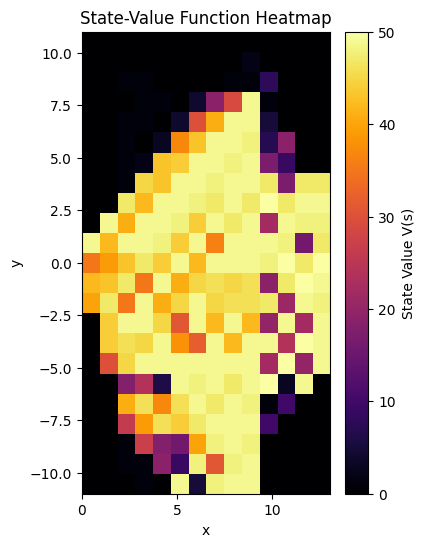

In [38]:
plot_state_value_function(best_agent_sarsa)